# Notebook setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)


Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import pandas as pd
from shutil import copyfile

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import load_model


from time import time

models_path = '/content/drive/MyDrive/deep_learning_models'

os.makedirs(models_path, exist_ok = True)


In [ ]:
CAMVID_CLASSES = {
    'Animal': (64, 128, 64),
    'Archway': (192, 0, 128),
    'Bicyclist': (0, 128, 192),
    'Bridge': (0, 128, 64),
    'Building': (128, 0, 0),
    'Car': (64, 0, 128),
    'CartLuggagePram': (64, 0, 192),
    'Child': (192, 128, 64),
    'Column_Pole': (192, 192, 128),
    'Fence': (64, 64, 128),
    'LaneMkgsDriv': (128, 0, 192),
    'LaneMkgsNonDriv': (192, 0, 64),
    'Misc_Text': (128, 128, 64),
    'MotorcycleScooter': (192, 0, 192),
    'OtherMoving': (128, 64, 64),
    'ParkingBlock': (64, 192, 128),
    'Pedestrian': (64, 64, 0),
    'Road': (128, 64, 128),
    'RoadShoulder': (128, 128, 192),
    'Sidewalk': (0, 0, 192),
    'SignSymbol': (192, 128, 128),
    'Sky': (128, 128, 128),
    'SUVPickupTruck': (64, 128, 192),
    'TrafficCone': (0, 0, 64),
    'TrafficLight': (0, 64, 64),
    'Train': (192, 64, 128),
    'Tree': (128, 128, 0),
    'Truck_Bus': (192, 128, 192),
    'Tunnel': (64, 0, 64),
    'VegetationMisc': (192, 192, 0),
    'Void': (0, 0, 0),
    'Wall': (64, 192, 0)
}

num_classes = len(CAMVID_CLASSES)


In [ ]:
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/drive/MyDrive/semantic-segmentation-camvid/Data/raw.zip', 'raw.zip')
# Extract files
zipp = zipfile.ZipFile('raw.zip')

data_raw_path = '/content/data/'

zipp.extractall(data_raw_path)
zipp.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 29.326 seconds


# Data Loading and Preprocessing

In [ ]:
#train test split
base_dir = "/content/data/raw"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

train_dir = "/content/data/processed/train"
test_dir = "/content/data/processed/test"

train_images_dir = os.path.join(train_dir, "images")
train_labels_dir = os.path.join(train_dir, "labels")
test_images_dir = os.path.join(test_dir, "images")
test_labels_dir = os.path.join(test_dir, "labels")

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)


In [ ]:
all_images = os.listdir(images_dir)
all_images.sort()
seed_value = 42
np.random.seed(seed_value)
np.random.shuffle(all_images)

train_size = int(0.8 * len(all_images))
train_images = all_images[:train_size]
test_images = all_images[train_size:]

# Copia le immagini e le maschere nel set di addestramento
for image_file in train_images:
    shutil.copy(os.path.join(images_dir, image_file), os.path.join(train_images_dir, image_file))
    # Aggiungi "_L" al nome file per la maschera
    label_file = image_file[:-4] + '_L.png'  # Rimuove '.png' e aggiunge '_L.png'
    shutil.copy(os.path.join(labels_dir, label_file), os.path.join(train_labels_dir, label_file))

# Copia le immagini e le maschere nel set di test
for image_file in test_images:
    shutil.copy(os.path.join(images_dir, image_file), os.path.join(test_images_dir, image_file))
    label_file = image_file[:-4] + '_L.png'
    shutil.copy(os.path.join(labels_dir, label_file), os.path.join(test_labels_dir, label_file))



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CamVidDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, class_colors, batch_size=16, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_colors = class_colors
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[i: i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.target_size + (3,), dtype='float32')
        y = np.zeros((self.batch_size,) + self.target_size, dtype='int32')  # 2D labels

        for j, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
            img = load_img(image_path, target_size=self.target_size)
            mask = load_img(mask_path, target_size=self.target_size, color_mode='rgb')

            img = img_to_array(img)
            mask = img_to_array(mask)

            mask = self.form_2D_label(mask)

            x[j] = img / 255.0
            y[j] = mask  # assign 2D labels

        return x, y

    def form_2D_label(self, mask):
        label = np.zeros(mask.shape[:2], dtype=np.uint8)
        for i, rgb in enumerate(self.class_colors):
            label[(mask == rgb).all(axis=-1)] = i
        return label


# Uso del generatore:
from sklearn.model_selection import train_test_split

# Percorsi immagini e maschere
image_paths = [os.path.join('data/processed/train/images', fname) for fname in os.listdir('data/processed/train/images')]
mask_paths = [os.path.join('data/processed/train/labels', fname) for fname in os.listdir('data/processed/train/labels')]

# Assicurati che i percorsi siano ordinati e corrispondenti
image_paths.sort()
mask_paths.sort()

# Split in train e validation
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Creazione del generatore
train_gen = CamVidDataGenerator(train_images, train_masks, list(CAMVID_CLASSES.values()))
val_gen = CamVidDataGenerator(val_images, val_masks, list(CAMVID_CLASSES.values()))



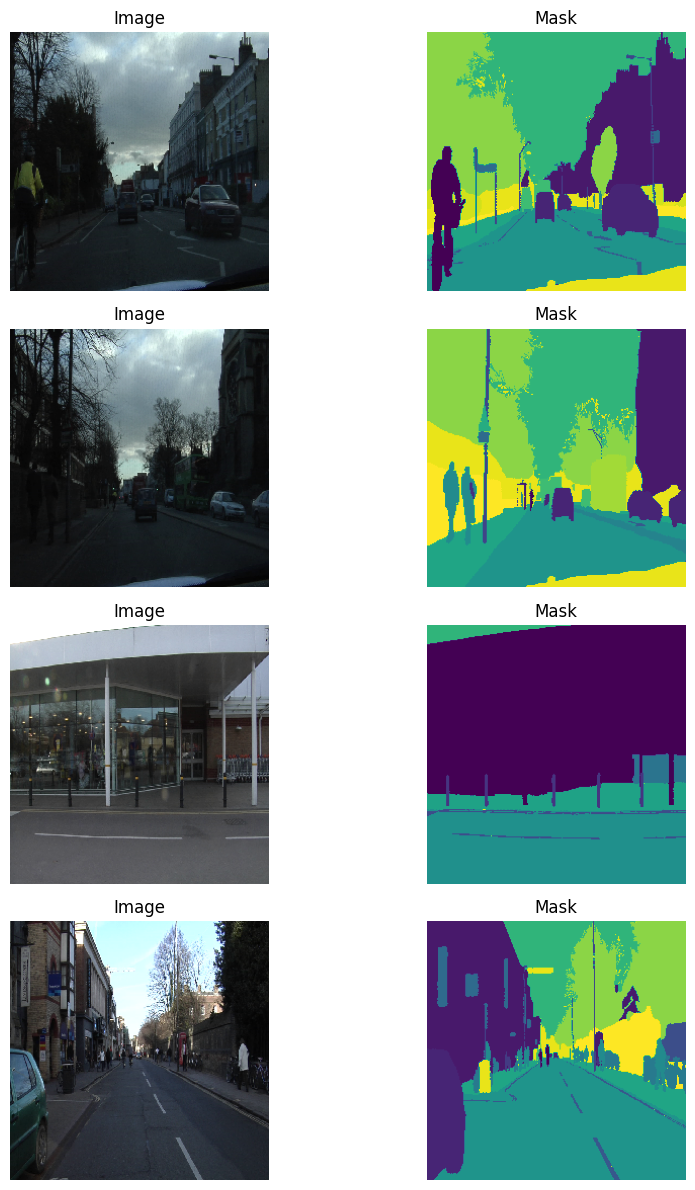

In [ ]:
import matplotlib.pyplot as plt

# Funzione per plottare immagini e maschere
def plot_images_and_masks(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))  # 2 colonne per immagini e maschere
    for i in range(num_samples):
        ax1, ax2 = axes[i]
        # Visualizza l'immagine
        ax1.imshow(images[i])
        ax1.set_title('Image')
        ax1.axis('off')

        # Visualizza la maschera corrispondente
        ax2.imshow(masks[i])  # Assicurati che la maschera sia indexata correttamente
        ax2.set_title('Mask')
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Estrai un batch casuale di dati
x, y = next(iter(train_gen))  # Prende il primo batch; per semplicità, non necessariamente casuale

# Seleziona 5 campioni casuali dall'batch
indices = np.random.choice(x.shape[0], 4, replace=False)
selected_images = x[indices]
selected_masks = y[indices]

# Chiama la funzione per plottare
plot_images_and_masks(selected_images, selected_masks, num_samples=4)


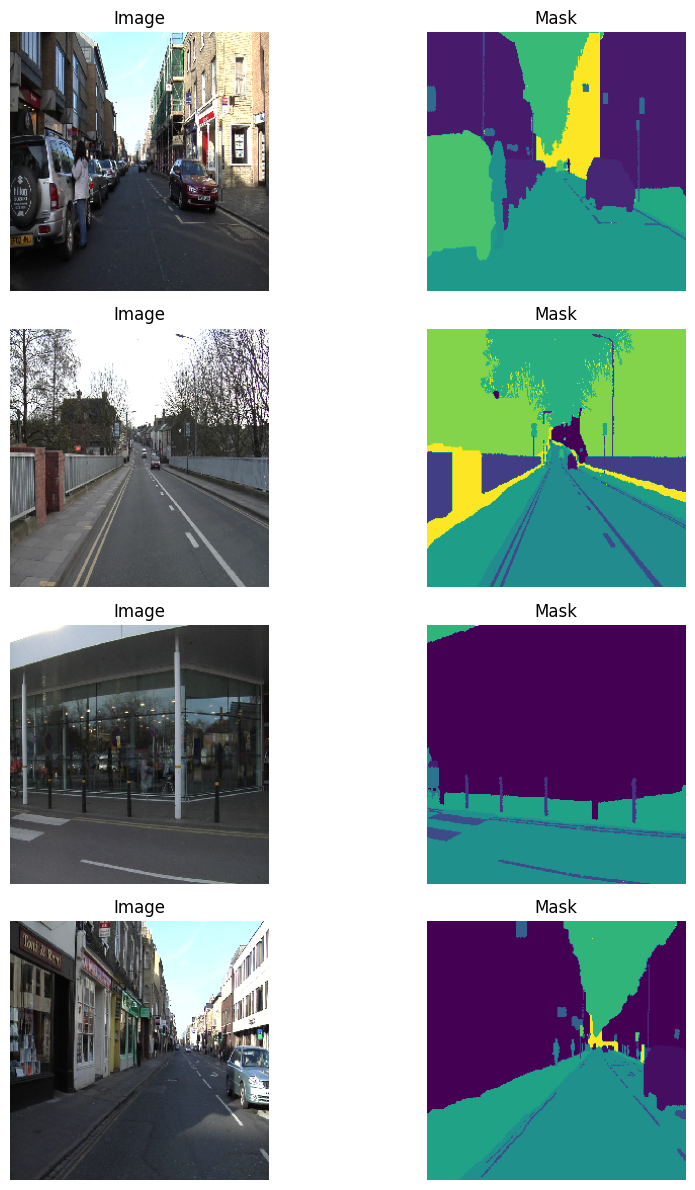

In [ ]:
import matplotlib.pyplot as plt

# Funzione per plottare immagini e maschere
def plot_images_and_masks(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))  # 2 colonne per immagini e maschere
    for i in range(num_samples):
        ax1, ax2 = axes[i]
        # Visualizza l'immagine
        ax1.imshow(images[i])
        ax1.set_title('Image')
        ax1.axis('off')

        # Visualizza la maschera corrispondente
        ax2.imshow(masks[i])  # Assicurati che la maschera sia indexata correttamente
        ax2.set_title('Mask')
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Estrai un batch casuale di dati
x, y = next(iter(val_gen))  # Prende il primo batch; per semplicità, non necessariamente casuale

# Seleziona 5 campioni casuali dall'batch
indices = np.random.choice(x.shape[0], 4, replace=False)
selected_images = x[indices]
selected_masks = y[indices]

# Chiama la funzione per plottare
plot_images_and_masks(selected_images, selected_masks, num_samples=4)


Processing masks: 100%|██████████| 448/448 [10:23<00:00,  1.39s/it]


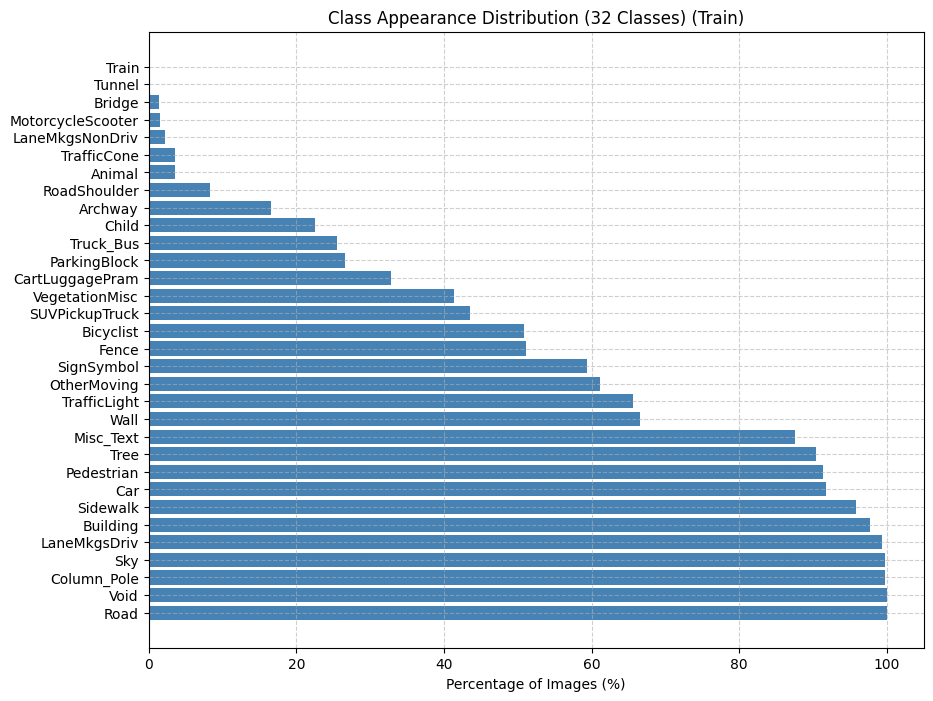

Class Appearance: {'Animal': 16, 'Archway': 74, 'Bicyclist': 228, 'Bridge': 6, 'Building': 438, 'Car': 411, 'CartLuggagePram': 147, 'Child': 101, 'Column_Pole': 447, 'Fence': 229, 'LaneMkgsDriv': 445, 'LaneMkgsNonDriv': 10, 'Misc_Text': 392, 'MotorcycleScooter': 7, 'OtherMoving': 274, 'ParkingBlock': 119, 'Pedestrian': 409, 'Road': 448, 'RoadShoulder': 37, 'Sidewalk': 429, 'SignSymbol': 266, 'Sky': 447, 'SUVPickupTruck': 195, 'TrafficCone': 16, 'TrafficLight': 294, 'Train': 0, 'Tree': 405, 'Truck_Bus': 114, 'Tunnel': 1, 'VegetationMisc': 185, 'Void': 448, 'Wall': 298}
Class Appearance Percentage: {'Animal': 3.571428571428571, 'Archway': 16.517857142857142, 'Bicyclist': 50.89285714285714, 'Bridge': 1.3392857142857142, 'Building': 97.76785714285714, 'Car': 91.74107142857143, 'CartLuggagePram': 32.8125, 'Child': 22.544642857142858, 'Column_Pole': 99.77678571428571, 'Fence': 51.11607142857143, 'LaneMkgsDriv': 99.33035714285714, 'LaneMkgsNonDriv': 2.232142857142857, 'Misc_Text': 87.5, 'Moto

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Inizializza il conteggio delle apparizioni delle classi
rgb_to_class = {v: k for k, v in CAMVID_CLASSES.items()}
class_appearance = {k: 0 for k in CAMVID_CLASSES.keys()}

train_masks_cv  = [img_to_array(load_img(path)) for path in train_masks]


# Creazione di una mappa per contare più efficientemente
color_map = np.zeros((256, 256, 256), dtype=np.int32)

# Aggiorna la color_map con i conteggi dei colori nelle maschere
from tqdm import tqdm
for mask in tqdm(train_masks_cv, desc="Processing masks"):

    mask_int = mask.astype(int)  # Converti i valori delle maschere in interi
    # Trova i colori presenti nella maschera
    unique_colors = np.unique(mask_int.reshape(-1, 3), axis=0)
    # Incrementa solo una volta per ogni colore presente
    for color in unique_colors:
        np.add.at(color_map, tuple(color), 1)


# Convertire color_map in conteggi utili
for rgb, class_name in rgb_to_class.items():
    class_appearance[class_name] = np.sum(color_map[rgb])

total_images = len(train_masks_cv)

# Calcola la frequenza relativa come percentuale
class_appearance_percentage = {k: (v / total_images) * 100 for k, v in class_appearance.items()}

# Ordina le classi per apparizione
sorted_classes = sorted(class_appearance_percentage, key=class_appearance_percentage.get, reverse=True)
sorted_percentages = [class_appearance_percentage[cls] for cls in sorted_classes]

# Plot the class appearance distribution
plt.figure(figsize=(10, 8))
plt.barh(sorted_classes, sorted_percentages, color='steelblue')
plt.xlabel('Percentage of Images (%)')
plt.title('Class Appearance Distribution (32 Classes) (Train)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print results
print("Class Appearance:", class_appearance)
print("Class Appearance Percentage:", class_appearance_percentage)
print("Total Images:", total_images)


Processing masks: 100%|██████████| 112/112 [02:31<00:00,  1.35s/it]


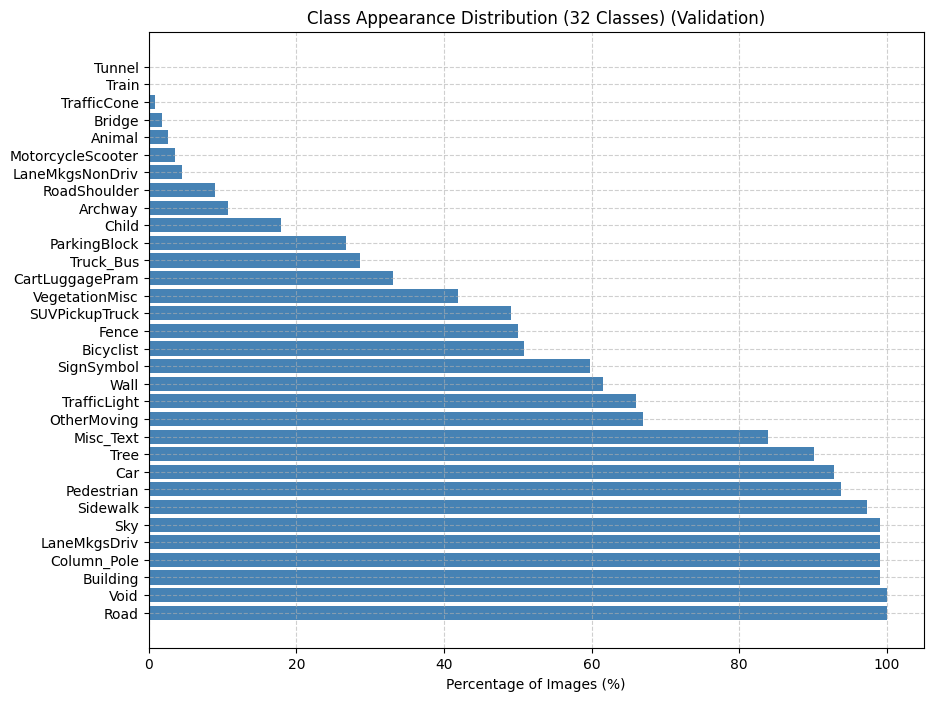

Class Appearance: {'Animal': 3, 'Archway': 12, 'Bicyclist': 57, 'Bridge': 2, 'Building': 111, 'Car': 104, 'CartLuggagePram': 37, 'Child': 20, 'Column_Pole': 111, 'Fence': 56, 'LaneMkgsDriv': 111, 'LaneMkgsNonDriv': 5, 'Misc_Text': 94, 'MotorcycleScooter': 4, 'OtherMoving': 75, 'ParkingBlock': 30, 'Pedestrian': 105, 'Road': 112, 'RoadShoulder': 10, 'Sidewalk': 109, 'SignSymbol': 67, 'Sky': 111, 'SUVPickupTruck': 55, 'TrafficCone': 1, 'TrafficLight': 74, 'Train': 0, 'Tree': 101, 'Truck_Bus': 32, 'Tunnel': 0, 'VegetationMisc': 47, 'Void': 112, 'Wall': 69}
Class Appearance Percentage: {'Animal': 2.6785714285714284, 'Archway': 10.714285714285714, 'Bicyclist': 50.89285714285714, 'Bridge': 1.7857142857142856, 'Building': 99.10714285714286, 'Car': 92.85714285714286, 'CartLuggagePram': 33.035714285714285, 'Child': 17.857142857142858, 'Column_Pole': 99.10714285714286, 'Fence': 50.0, 'LaneMkgsDriv': 99.10714285714286, 'LaneMkgsNonDriv': 4.464285714285714, 'Misc_Text': 83.92857142857143, 'Motorcyc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Inizializza il conteggio delle apparizioni delle classi
rgb_to_class = {v: k for k, v in CAMVID_CLASSES.items()}
class_appearance = {k: 0 for k in CAMVID_CLASSES.keys()}

# Creazione di una mappa per contare più efficientemente
color_map = np.zeros((256, 256, 256), dtype=np.int32)

val_masks_cv  = [img_to_array(load_img(path)) for path in val_masks]


# Aggiorna la color_map con i conteggi dei colori nelle maschere
from tqdm import tqdm
for mask in tqdm(val_masks_cv, desc="Processing masks"):

    mask_int = mask.astype(int)  # Converti i valori delle maschere in interi
    # Trova i colori presenti nella maschera
    unique_colors = np.unique(mask_int.reshape(-1, 3), axis=0)
    # Incrementa solo una volta per ogni colore presente
    for color in unique_colors:
        np.add.at(color_map, tuple(color), 1)


# Convertire color_map in conteggi utili
for rgb, class_name in rgb_to_class.items():
    class_appearance[class_name] = np.sum(color_map[rgb])

total_images = len(val_masks_cv)

# Calcola la frequenza relativa come percentuale
class_appearance_percentage = {k: (v / total_images) * 100 for k, v in class_appearance.items()}

# Ordina le classi per apparizione
sorted_classes = sorted(class_appearance_percentage, key=class_appearance_percentage.get, reverse=True)
sorted_percentages = [class_appearance_percentage[cls] for cls in sorted_classes]

# Plot the class appearance distribution
plt.figure(figsize=(10, 8))
plt.barh(sorted_classes, sorted_percentages, color='steelblue')
plt.xlabel('Percentage of Images (%)')
plt.title('Class Appearance Distribution (32 Classes) (Validation)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print results
print("Class Appearance:", class_appearance)
print("Class Appearance Percentage:", class_appearance_percentage)
print("Total Images:", total_images)


Processing masks: 100%|██████████| 141/141 [03:09<00:00,  1.34s/it]


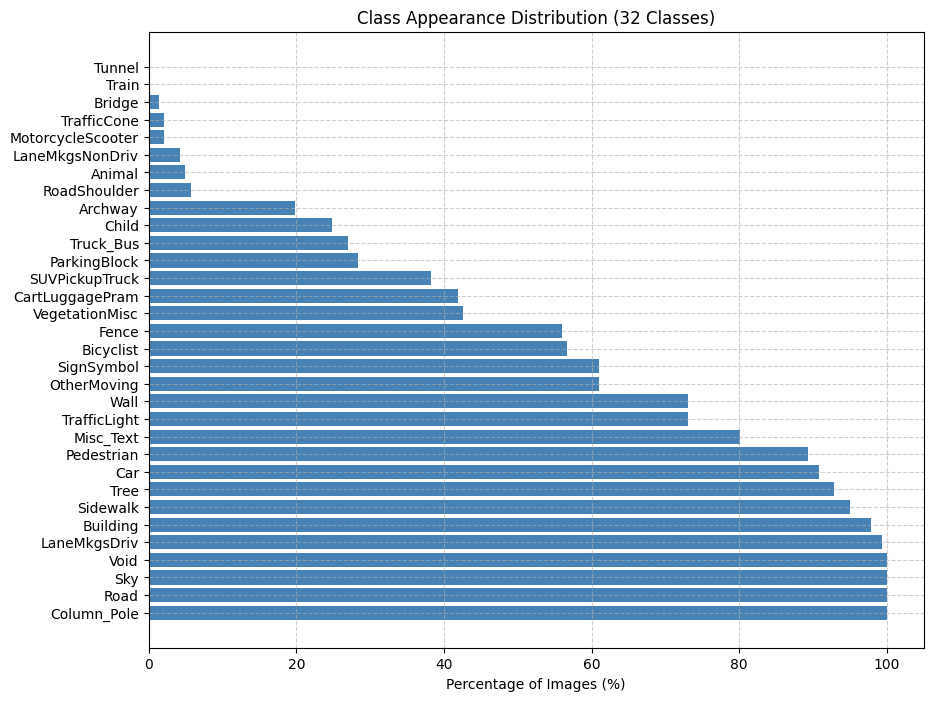

Class Appearance: {'Animal': 7, 'Archway': 28, 'Bicyclist': 80, 'Bridge': 2, 'Building': 138, 'Car': 128, 'CartLuggagePram': 59, 'Child': 35, 'Column_Pole': 141, 'Fence': 79, 'LaneMkgsDriv': 140, 'LaneMkgsNonDriv': 6, 'Misc_Text': 113, 'MotorcycleScooter': 3, 'OtherMoving': 86, 'ParkingBlock': 40, 'Pedestrian': 126, 'Road': 141, 'RoadShoulder': 8, 'Sidewalk': 134, 'SignSymbol': 86, 'Sky': 141, 'SUVPickupTruck': 54, 'TrafficCone': 3, 'TrafficLight': 103, 'Train': 0, 'Tree': 131, 'Truck_Bus': 38, 'Tunnel': 0, 'VegetationMisc': 60, 'Void': 141, 'Wall': 103}
Class Appearance Percentage: {'Animal': 4.964539007092199, 'Archway': 19.858156028368796, 'Bicyclist': 56.73758865248227, 'Bridge': 1.4184397163120568, 'Building': 97.87234042553192, 'Car': 90.78014184397163, 'CartLuggagePram': 41.843971631205676, 'Child': 24.822695035460992, 'Column_Pole': 100.0, 'Fence': 56.02836879432624, 'LaneMkgsDriv': 99.29078014184397, 'LaneMkgsNonDriv': 4.25531914893617, 'Misc_Text': 80.1418439716312, 'Motorcyc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_masks = [os.path.join('data/processed/test/labels', fname) for fname in os.listdir('data/processed/test/labels')]

test_masks_cv  = [img_to_array(load_img(path)) for path in test_masks]

# Inizializza il conteggio delle apparizioni delle classi
rgb_to_class = {v: k for k, v in CAMVID_CLASSES.items()}
class_appearance = {k: 0 for k in CAMVID_CLASSES.keys()}

# Creazione di una mappa per contare più efficientemente
color_map = np.zeros((256, 256, 256), dtype=np.int32)

# Aggiorna la color_map con i conteggi dei colori nelle maschere
from tqdm import tqdm
for mask in tqdm(test_masks_cv, desc="Processing masks"):

    mask_int = mask.astype(int)  # Converti i valori delle maschere in interi
    # Trova i colori presenti nella maschera
    unique_colors = np.unique(mask_int.reshape(-1, 3), axis=0)
    # Incrementa solo una volta per ogni colore presente
    for color in unique_colors:
        np.add.at(color_map, tuple(color), 1)


# Convertire color_map in conteggi utili
for rgb, class_name in rgb_to_class.items():
    class_appearance[class_name] = np.sum(color_map[rgb])

total_images = len(test_masks_cv)

# Calcola la frequenza relativa come percentuale
class_appearance_percentage = {k: (v / total_images) * 100 for k, v in class_appearance.items()}

# Ordina le classi per apparizione
sorted_classes = sorted(class_appearance_percentage, key=class_appearance_percentage.get, reverse=True)
sorted_percentages = [class_appearance_percentage[cls] for cls in sorted_classes]

# Plot the class appearance distribution
plt.figure(figsize=(10, 8))
plt.barh(sorted_classes, sorted_percentages, color='steelblue')
plt.xlabel('Percentage of Images (%)')
plt.title('Class Appearance Distribution (32 Classes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print results
print("Class Appearance:", class_appearance)
print("Class Appearance Percentage:", class_appearance_percentage)
print("Total Images:", total_images)


# Metrics Definition

In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None, ignore_class=None, sparse_y_true=True, sparse_y_pred=True, axis=-1):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.ignore_class = ignore_class
        self.sparse_y_true = sparse_y_true
        self.sparse_y_pred = sparse_y_pred
        self.axis = axis

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=self.axis)
        y_true = tf.cast(y_true, tf.int64)
        return super().update_state(y_true, y_pred, sample_weight)

mean_iou_metric = CustomMeanIoU(num_classes=num_classes, name = 'custom_mean_io_u')



# Results utils functions

In [ ]:
def plot_training_results(log_path, model_name):
    # Caricare i log dell'allenamento dal file CSV
    logs = pd.read_csv(log_path)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(logs['accuracy'])
    plt.plot(logs['val_accuracy'])
    plt.title(f'Model Accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(logs['loss'])
    plt.plot(logs['val_loss'])
    plt.title(f'Model Loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation Mean IoU values
    plt.figure(figsize=(12, 6))
    plt.plot(logs['custom_mean_io_u'])
    plt.plot(logs['val_custom_mean_io_u'])
    plt.title(f'Model Mean IoU - {model_name}')
    plt.ylabel('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylim(0, 0.7)  # Set y-axis limit for Mean IoU
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
selected_indices = None


In [ ]:
# Creazione della mappa dei colori
class_colors = np.array(list(CAMVID_CLASSES.values()))

def plot_predictions(model, data_generator, num_samples=5, indices=None):
    global selected_indices

    # Ottenere il numero di batch
    num_batches = len(data_generator)

    # Pescare un batch di immagini dal generatore
    x, y_true = data_generator[2]

    # Selezionare casualmente num_samples indici la prima volta
    if selected_indices is None:
        selected_indices = np.random.choice(x.shape[0], num_samples, replace=False)

    # Effettuare predizioni con il modello
    y_pred = model.predict(x)

    # Funzione per mappare le maschere ai colori
    def colorize_mask(mask):
        color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i in range(len(class_colors)):
            color_mask[mask == i] = class_colors[i]
        return color_mask

    # Creare i plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    for i, idx in enumerate(selected_indices):
        # Immagine originale
        axes[i, 0].imshow(x[idx])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Maschera vera
        true_mask_colored = colorize_mask(np.squeeze(y_true[idx]))
        axes[i, 1].imshow(true_mask_colored)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')

        # Maschera predetta
        pred_mask = np.argmax(y_pred[idx], axis=-1)
        pred_mask_colored = colorize_mask(pred_mask)
        axes[i, 2].imshow(pred_mask_colored)
        axes[i, 2].set_title(f'Predicted Mask - {model.name}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Augmentation

In [ ]:
data_gen_args = dict(
    horizontal_flip=True
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

class AugmentedCamVidDataGenerator(Sequence):
    def __init__(self, generator, batch_size, image_datagen, mask_datagen):
        self.generator = generator
        self.batch_size = batch_size
        self.image_datagen = image_datagen
        self.mask_datagen = mask_datagen

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        x, y = self.generator[idx]

        seed = np.random.randint(0, 10000)
        g_x = self.image_datagen.flow(x, batch_size=self.batch_size, seed=seed, shuffle=False)

        # Espandere le dimensioni di y per renderlo compatibile con ImageDataGenerator
        y_expanded = np.expand_dims(y, axis=-1)
        g_y = self.mask_datagen.flow(y_expanded, batch_size=self.batch_size, seed=seed, shuffle=False)

        x_augmented = g_x.next()
        y_augmented = g_y.next()

        # Rimuovere l'ultima dimensione per riportarlo alla forma originale
        y_augmented = np.squeeze(y_augmented, axis=-1)

        return x_augmented, y_augmented

# Creare il generatore combinato
train_aug_gen = AugmentedCamVidDataGenerator(train_gen, batch_size=16, image_datagen=image_datagen, mask_datagen=mask_datagen)

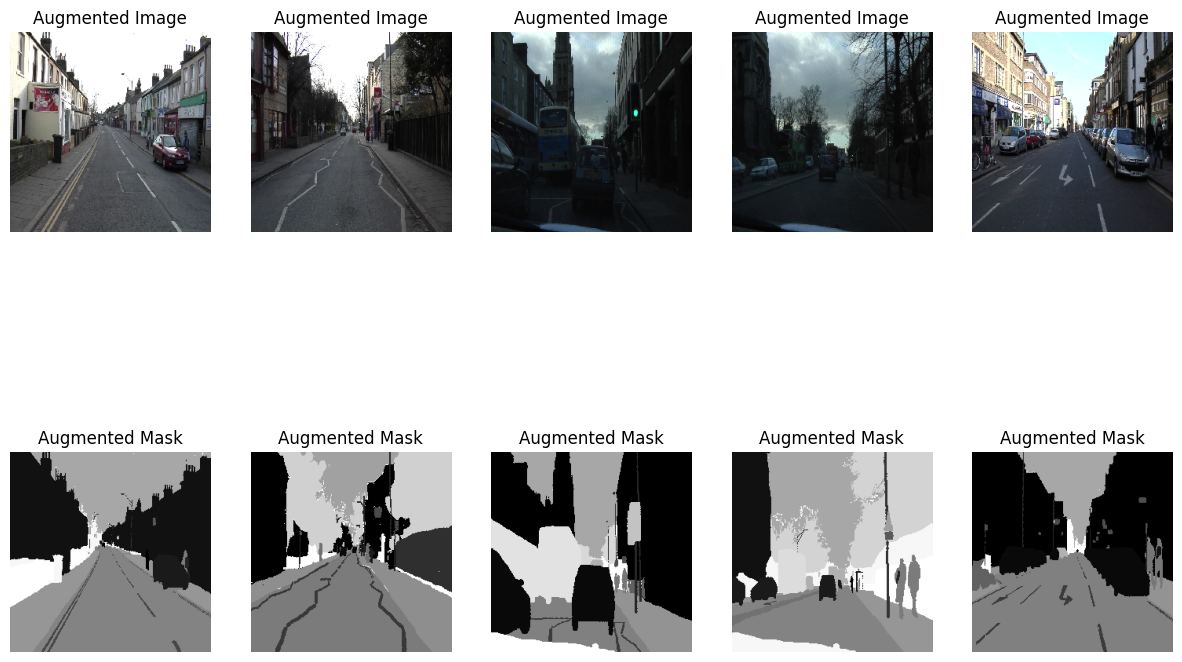

In [ ]:
# Estrarre il primo batch dal generatore
x_augmented, y_augmented = train_aug_gen[0]

# Funzione per visualizzare le immagini e le loro maschere
def display_augmented_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Immagini originali augmentate
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title('Augmented Image')
        plt.axis('off')

        # Maschere corrispondenti
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')
    plt.show()

# Visualizzare 5 immagini augmentate e le loro maschere
display_augmented_images(x_augmented, y_augmented, num_images=5)

# Training

## Training Utils

In [ ]:
def train_or_resume_model(model, augmentation = False):

  model_name = model.name
  model_folder = os.path.join(models_path, model_name)
  os.makedirs(model_folder, exist_ok = True)

  checkpoint_path = os.path.join(model_folder, f'{model_name}.keras')
  log_path = os.path.join(model_folder, f'{model_name}_log.csv')
  if os.path.exists(log_path):
        append_logs = True
  else:
        append_logs = False
  if os.path.exists(checkpoint_path):
    print("Caricamento del modello dal checkpoint...")
    model = load_model(checkpoint_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
  else:
    model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', CustomMeanIoU(num_classes=len(CAMVID_CLASSES), name = "custom_mean_io_u")])

  callbacks = [
    EarlyStopping(patience=20, verbose=1, monitor='val_custom_mean_io_u', mode='max'),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_custom_mean_io_u', mode='max', save_weights_only=False),
    CSVLogger(log_path, append = append_logs),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)

  ]

  if augmentation:
    history = model.fit(train_aug_gen,
                        epochs=50,
                        validation_data=val_gen,
                        callbacks=callbacks)
  else:
    # Addestramento del modello
    history = model.fit(train_gen,
                        epochs=50,
                        validation_data=val_gen,
                        callbacks=callbacks)

  return history




## First Model

In [ ]:
model_name = 'first_model'

In [ ]:
# Funzione per costruire il modello U-Net con il core
def build_unet_with_core(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Core
    c = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    c = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(c)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = models.Model(inputs, outputs, name=model_name)
    return model

# Instanziare il modello
model = build_unet_with_core(input_shape=(256, 256, 3), num_classes=num_classes)

history = train_or_resume_model(model)

Epoch 1/50
28/28 [==============================] - 68s 2s/step - loss: 2.8984 - accuracy: 0.1758 - custom_mean_io_u: 0.0114 - val_loss: 2.4640 - val_accuracy: 0.2065 - val_custom_mean_io_u: 0.0109 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 59s 2s/step - loss: 2.2309 - accuracy: 0.3225 - custom_mean_io_u: 0.0226 - val_loss: 2.0545 - val_accuracy: 0.4741 - val_custom_mean_io_u: 0.0477 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 57s 2s/step - loss: 1.8809 - accuracy: 0.5164 - custom_mean_io_u: 0.0514 - val_loss: 1.7988 - val_accuracy: 0.5234 - val_custom_mean_io_u: 0.0589 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 57s 2s/step - loss: 1.6819 - accuracy: 0.5503 - custom_mean_io_u: 0.0592 - val_loss: 1.6752 - val_accuracy: 0.5395 - val_custom_mean_io_u: 0.0594 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 58s 2s/step - loss: 1.5828 - accuracy: 0.5590 - custom_mean_io_u: 0.0599 - val_loss: 1.5902 - val_accura

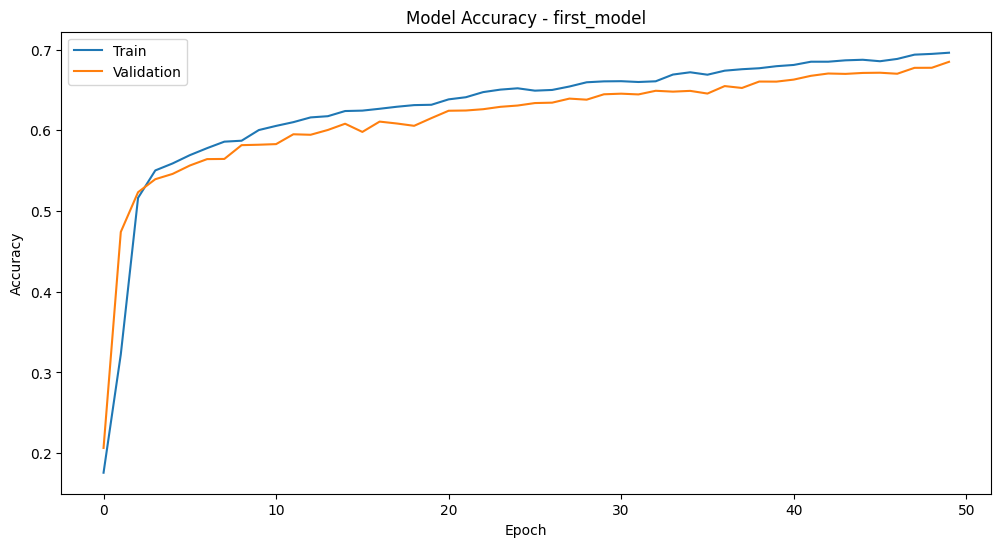

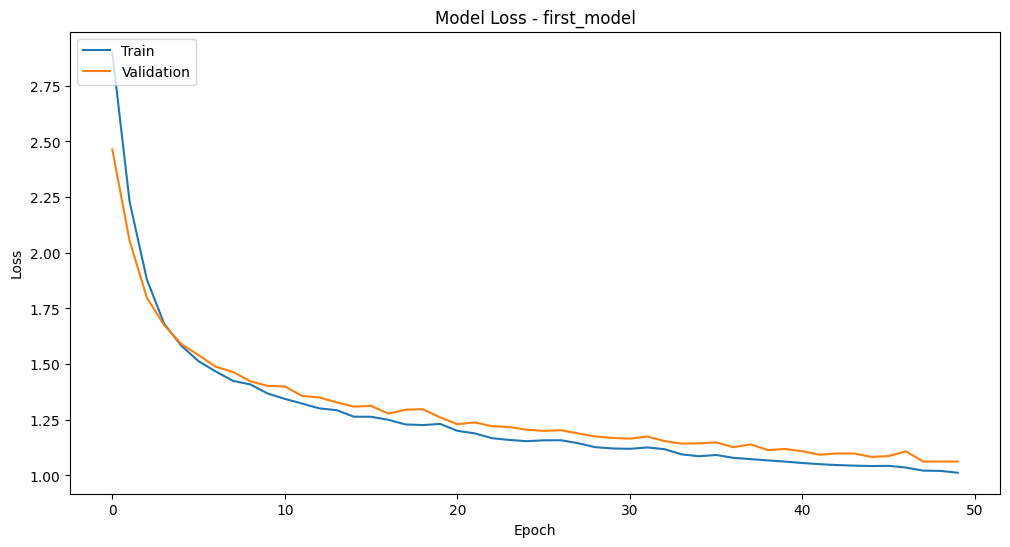

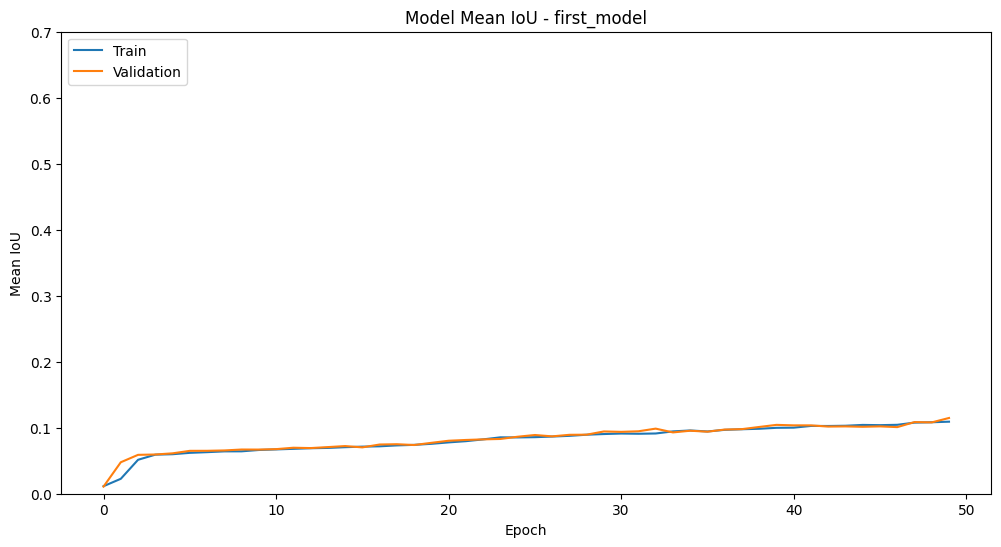

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  first_model
Total params: 75840
Trainable params: 75840
Non-trainable params: 0.0


## Second Model

In [ ]:
model_name = 'second_model'

In [ ]:
def build_unet_v2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    # Core
    c = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(c)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name='second_model')
    return model

# Instanziare il modello
input_shape = (256, 256, 3)
num_classes = len(CAMVID_CLASSES)
model = build_unet_v2(input_shape=input_shape, num_classes=num_classes)

history = train_or_resume_model(model)


Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 93s 2s/step - loss: 0.2658 - accuracy: 0.9179 - custom_mean_io_u: 0.4318 - val_loss: 0.5368 - val_accuracy: 0.8606 - val_custom_mean_io_u: 0.3130 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 59s 2s/step - loss: 0.2672 - accuracy: 0.9174 - custom_mean_io_u: 0.4327 - val_loss: 0.5828 - val_accuracy: 0.8518 - val_custom_mean_io_u: 0.3056 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 59s 2s/step - loss: 0.3885 - accuracy: 0.8833 - custom_mean_io_u: 0.3507 - val_loss: 0.5657 - val_accuracy: 0.8435 - val_custom_mean_io_u: 0.2699 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 59s 2s/step - loss: 0.3412 - accuracy: 0.8960 - custom_mean_io_u: 0.3713 - val_loss: 0.5125 - val_accuracy: 0.8631 - val_custom_mean_io_u: 0.3108 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 58s 2s/step - loss: 0.2724 - accuracy: 0.9163 - custom_mean_io

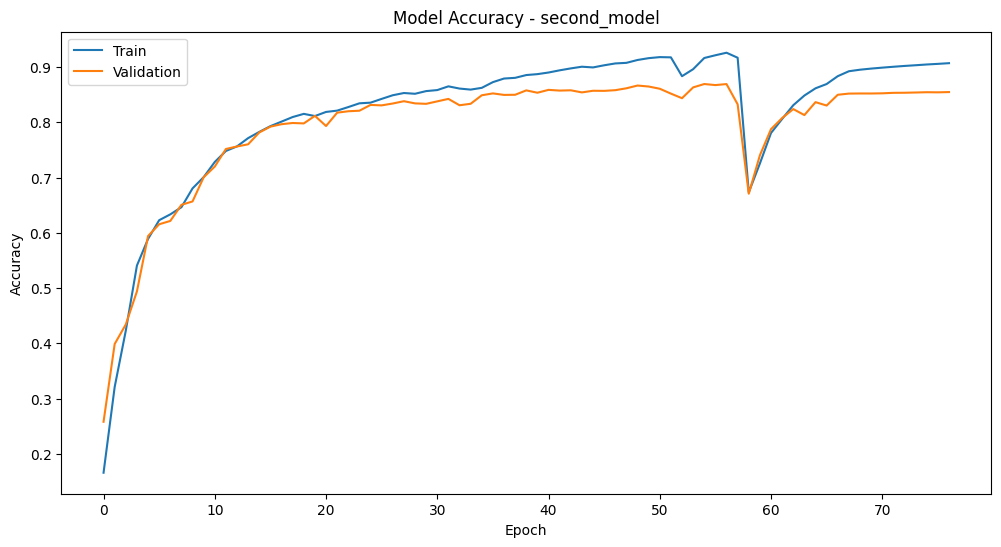

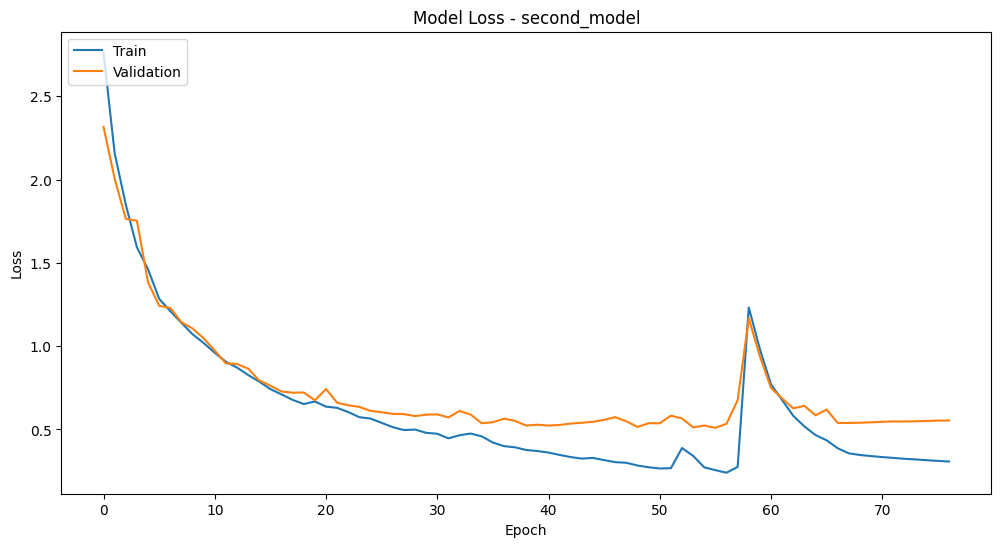

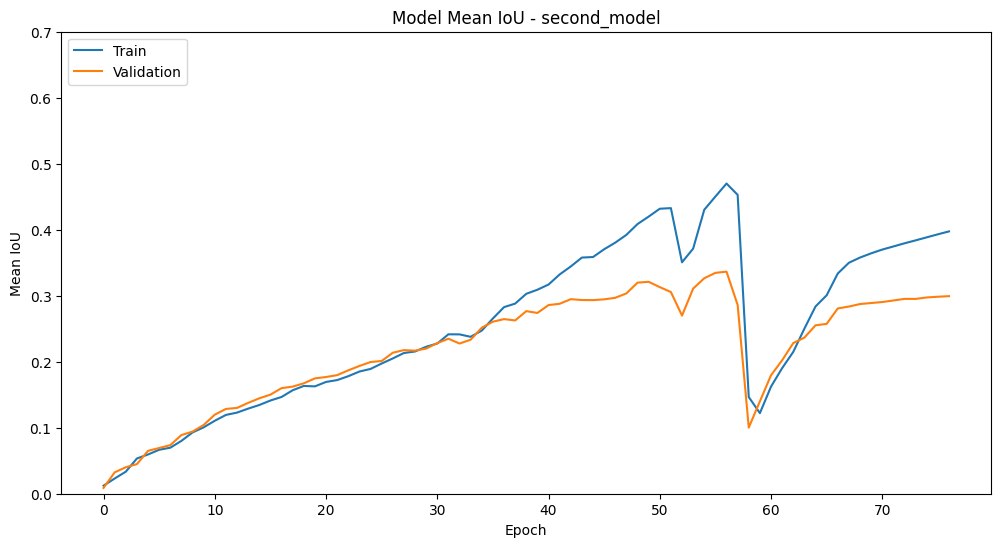

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  second_model
Total params: 2141664
Trainable params: 2141664
Non-trainable params: 0.0


## Third Model

In [ ]:
model_name = 'third_model'

In [ ]:
def build_unet_v3(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    # Core
    c = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(c)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name=model_name)
    return model

# Model instantiation
model = build_unet_v3(input_shape=(256, 256, 3), num_classes=len(CAMVID_CLASSES))

history = train_or_resume_model(model)

Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 78s 2s/step - loss: 0.4423 - accuracy: 0.8669 - custom_mean_io_u: 0.2554 - val_loss: 0.5493 - val_accuracy: 0.8483 - val_custom_mean_io_u: 0.2485 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 72s 3s/step - loss: 0.4459 - accuracy: 0.8665 - custom_mean_io_u: 0.2555 - val_loss: 0.5331 - val_accuracy: 0.8502 - val_custom_mean_io_u: 0.2562 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 74s 3s/step - loss: 0.4213 - accuracy: 0.8728 - custom_mean_io_u: 0.2707 - val_loss: 0.5234 - val_accuracy: 0.8517 - val_custom_mean_io_u: 0.2616 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 62s 2s/step - loss: 0.4175 - accuracy: 0.8739 - custom_mean_io_u: 0.2813 - val_loss: 0.5054 - val_accuracy: 0.8580 - val_custom_mean_io_u: 0.2690 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 62s 2s/step - loss: 0.4013 - accuracy: 0.8788 - custom_mean_io

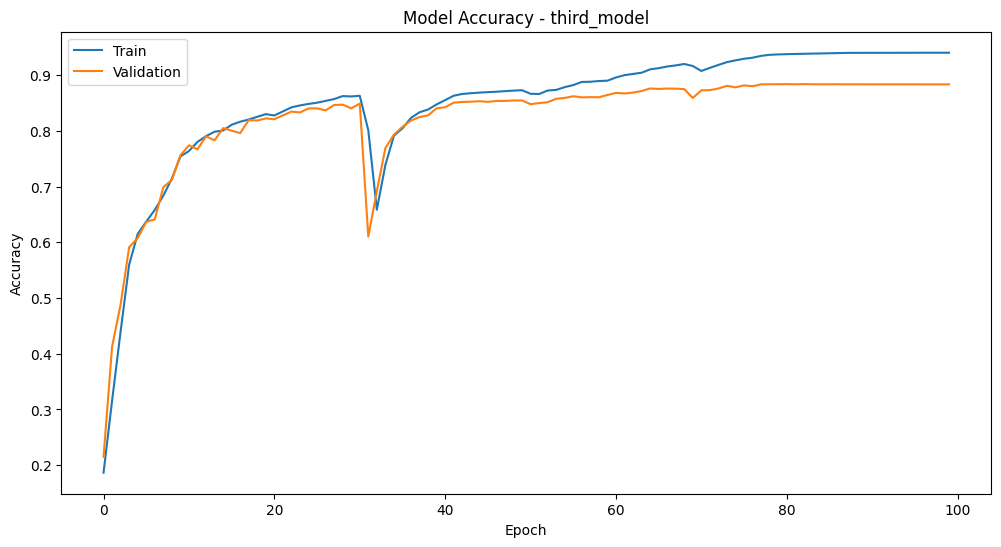

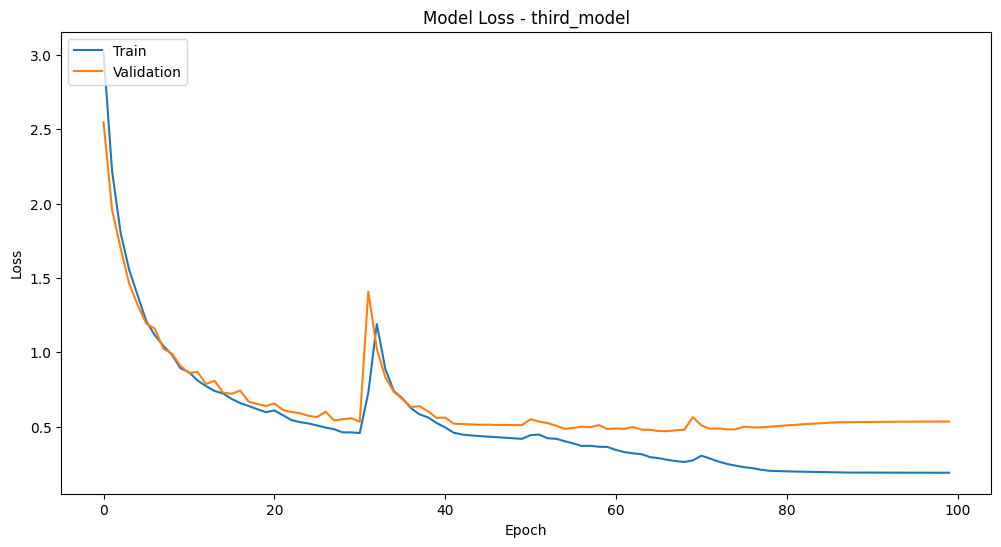

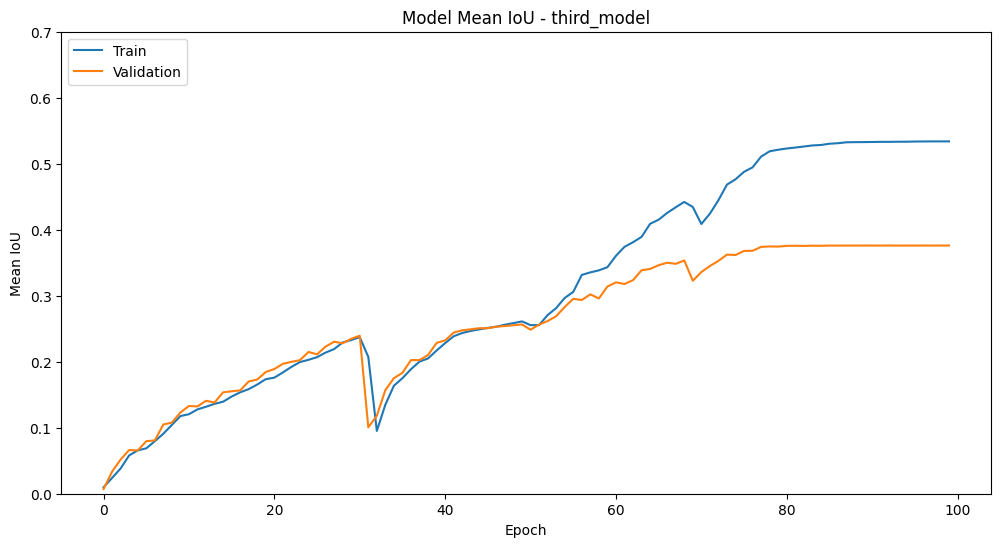

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  third_model
Total params: 8631520
Trainable params: 8631520
Non-trainable params: 0.0


## Fourth Model

In [ ]:
model_name = 'fourth_model'

In [ ]:
def build_unet_v4(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u5 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(c)
    u5 = layers.concatenate([u5, x5])
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u5)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name= model_name)
    return model

# Model instantiation
model = build_unet_v4(input_shape=(256, 256, 3), num_classes=len(CAMVID_CLASSES))

history = train_or_resume_model(model)

Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 109s 3s/step - loss: 0.2824 - accuracy: 0.9127 - custom_mean_io_u: 0.4191 - val_loss: 0.4624 - val_accuracy: 0.8788 - val_custom_mean_io_u: 0.3496 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 64s 2s/step - loss: 0.2772 - accuracy: 0.9142 - custom_mean_io_u: 0.4275 - val_loss: 0.4472 - val_accuracy: 0.8836 - val_custom_mean_io_u: 0.3528 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 63s 2s/step - loss: 0.2703 - accuracy: 0.9163 - custom_mean_io_u: 0.4343 - val_loss: 0.4562 - val_accuracy: 0.8826 - val_custom_mean_io_u: 0.3591 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 63s 2s/step - loss: 0.2582 - accuracy: 0.9194 - custom_mean_io_u: 0.4465 - val_loss: 0.4489 - val_accuracy: 0.8850 - val_custom_mean_io_u: 0.3705 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 72s 3s/step - loss: 0.2467 - accuracy: 0.9228 - custom_mean_i

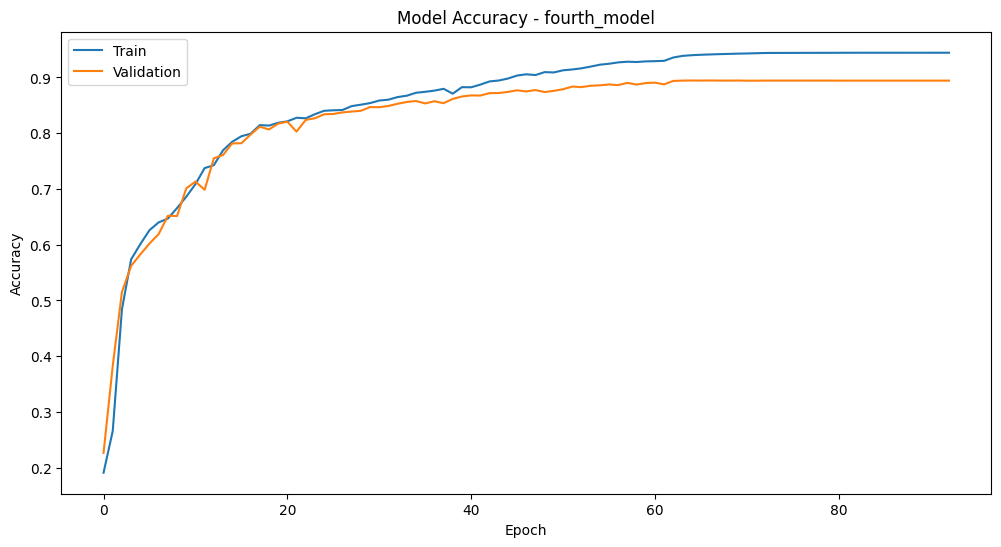

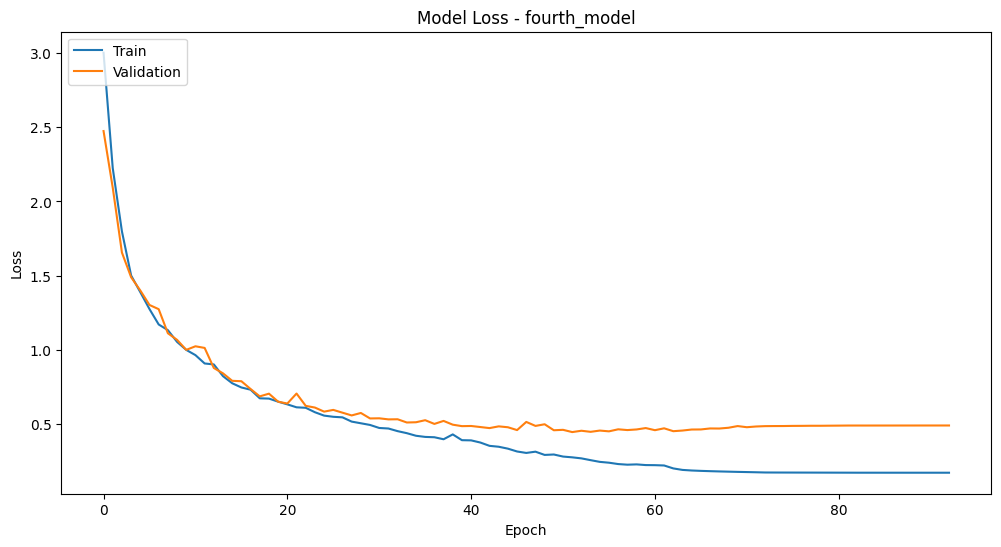

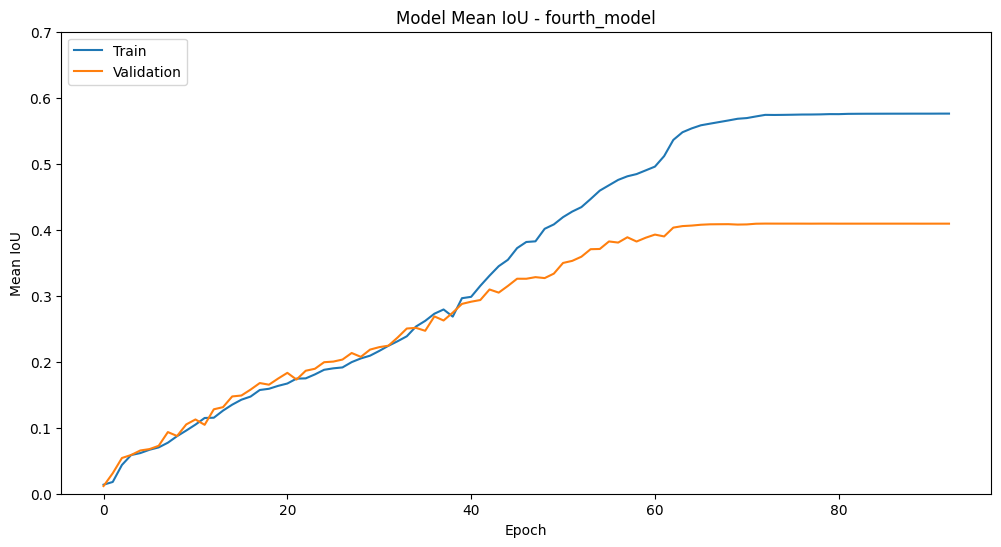

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fourth_model
Total params: 34587360
Trainable params: 34587360
Non-trainable params: 0.0


## Fifth Model

In [ ]:
model_name = 'fifth_model'

In [ ]:
from tensorflow.keras import layers, models

def build_unet_v5(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u5 = layers.Conv2DTranspose(1024, (3, 3), strides=2, activation='relu', padding='same')(c)
    u5 = layers.concatenate([u5, x5])
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(u5)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name=model_name)
    return model

# Model instantiation
model = build_unet_v5(input_shape=(256, 256, 3), num_classes=len(CAMVID_CLASSES))

history = train_or_resume_model(model)


Caricamento del modello dal checkpoint...
Epoch 1/50
28/28 [==============================] - 91s 3s/step - loss: 0.2980 - accuracy: 0.9070 - custom_mean_io_u: 0.4246 - val_loss: 0.4300 - val_accuracy: 0.8775 - val_custom_mean_io_u: 0.3592 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 70s 2s/step - loss: 0.3059 - accuracy: 0.9047 - custom_mean_io_u: 0.4160 - val_loss: 0.4492 - val_accuracy: 0.8774 - val_custom_mean_io_u: 0.3575 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 67s 2s/step - loss: 0.3122 - accuracy: 0.9034 - custom_mean_io_u: 0.4115 - val_loss: 0.4436 - val_accuracy: 0.8792 - val_custom_mean_io_u: 0.3476 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 90s 3s/step - loss: 0.3029 - accuracy: 0.9061 - custom_mean_io_u: 0.4194 - val_loss: 0.4249 - val_accuracy: 0.8848 - val_custom_mean_io_u: 0.3745 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 113s 4s/step - loss: 0.2797 - accuracy: 0.9128 - custom_mean_i

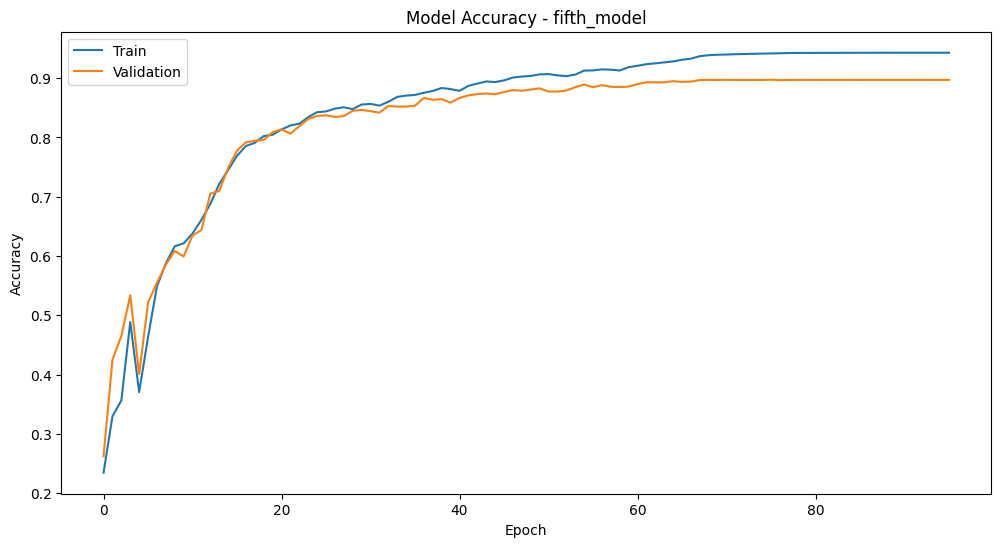

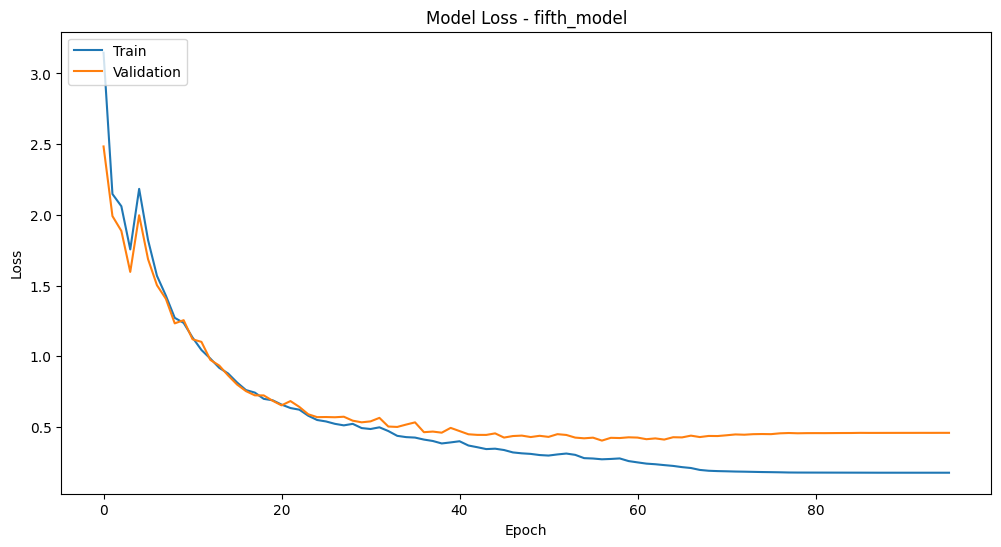

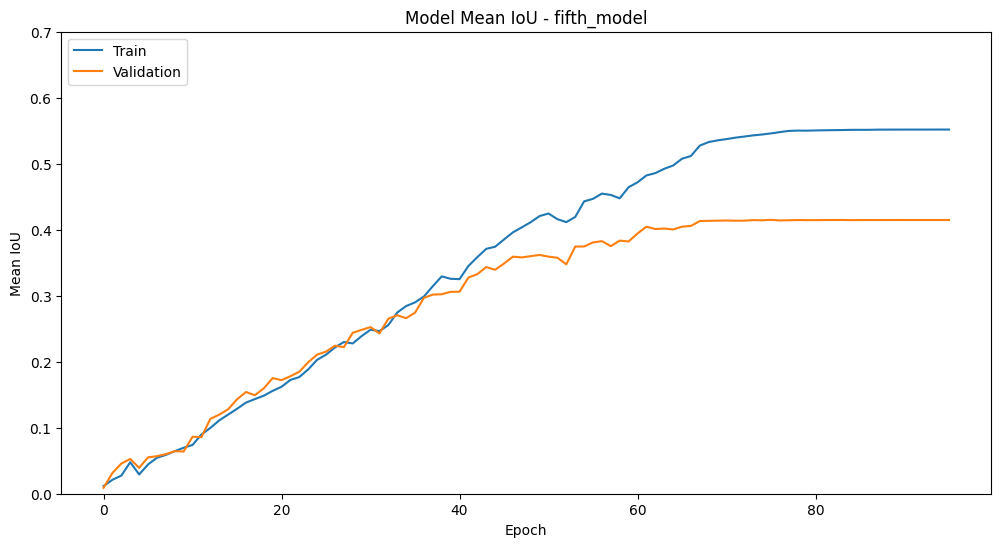

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fifth_model
Total params: 138331552
Trainable params: 138331552
Non-trainable params: 0.0


##Fifth model augmentation

In [ ]:
model_name = 'fifth_model_augmented'

In [ ]:
from tensorflow.keras import layers, models

def build_unet_v5(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    x3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    x4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    x4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    p4 = layers.MaxPooling2D((2, 2))(x4)

    x5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    x5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x5)
    p5 = layers.MaxPooling2D((2, 2))(x5)

    # Core
    c = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(p5)
    c = layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(c)

    # Decoder
    u5 = layers.Conv2DTranspose(1024, (3, 3), strides=2, activation='relu', padding='same')(c)
    u5 = layers.concatenate([u5, x5])
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(u5)

    u4 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation='relu', padding='same')(u5)
    u4 = layers.concatenate([u4, x4])
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(u4)
    u3 = layers.concatenate([u3, x3])
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(u3)
    u2 = layers.concatenate([u2, x2])
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u1 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(u2)
    u1 = layers.concatenate([u1, x1])
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u1)

    model = models.Model(inputs, outputs, name=model_name)
    return model

# Model instantiation
model = build_unet_v5(input_shape=(256, 256, 3), num_classes=len(CAMVID_CLASSES))

history = train_or_resume_model(model, augmentation = True)


Epoch 1/50
28/28 [==============================] - 134s 3s/step - loss: 2.4887 - accuracy: 0.2314 - custom_mean_io_u: 0.0160 - val_loss: 2.1796 - val_accuracy: 0.3339 - val_custom_mean_io_u: 0.0257 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 88s 3s/step - loss: 3.0171 - accuracy: 0.3699 - custom_mean_io_u: 0.0314 - val_loss: 2.4238 - val_accuracy: 0.4025 - val_custom_mean_io_u: 0.0343 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 90s 3s/step - loss: 2.3089 - accuracy: 0.3783 - custom_mean_io_u: 0.0293 - val_loss: 2.1227 - val_accuracy: 0.3369 - val_custom_mean_io_u: 0.0366 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 83s 3s/step - loss: 1.9304 - accuracy: 0.4077 - custom_mean_io_u: 0.0393 - val_loss: 1.8464 - val_accuracy: 0.4884 - val_custom_mean_io_u: 0.0485 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 85s 3s/step - loss: 1.7094 - accuracy: 0.5261 - custom_mean_io_u: 0.0513 - val_loss: 1.6183 - val_accur

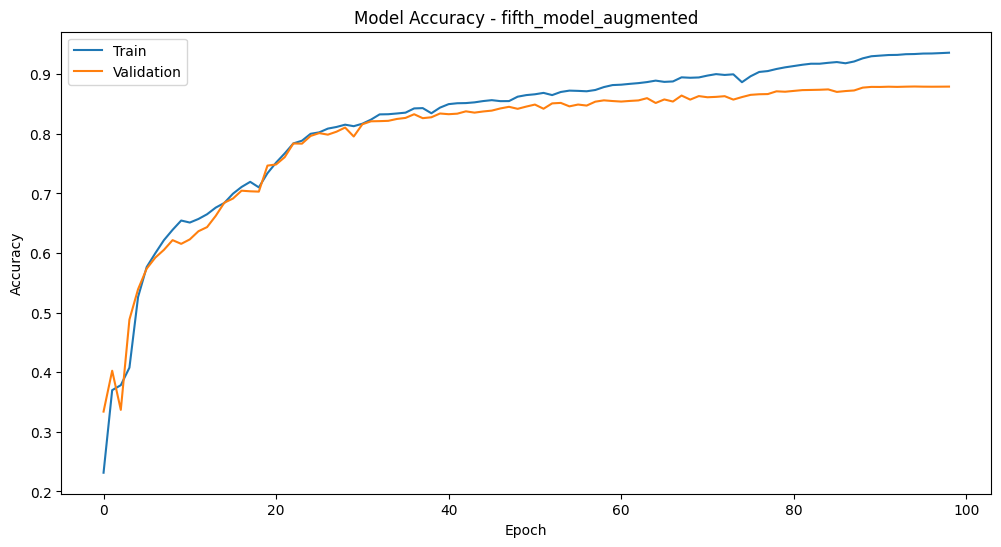

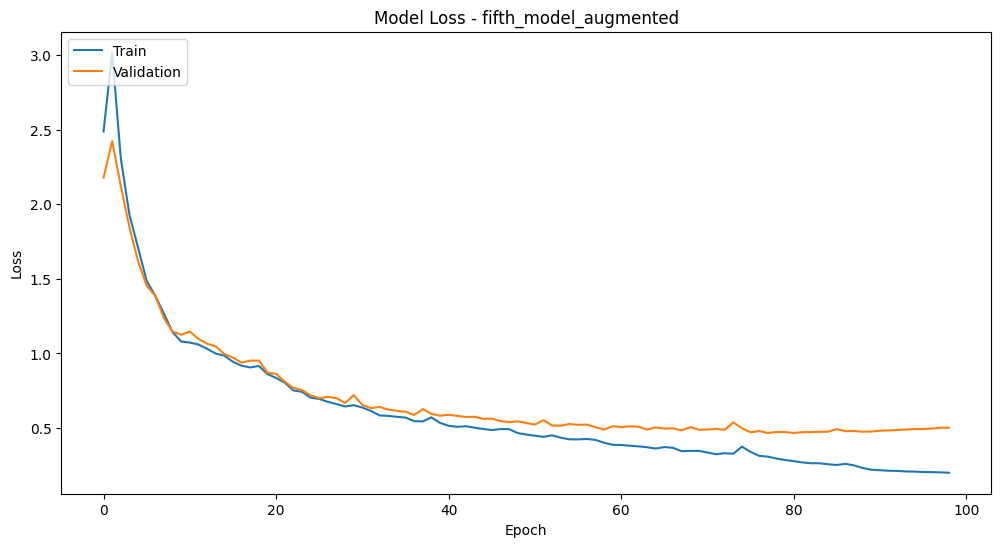

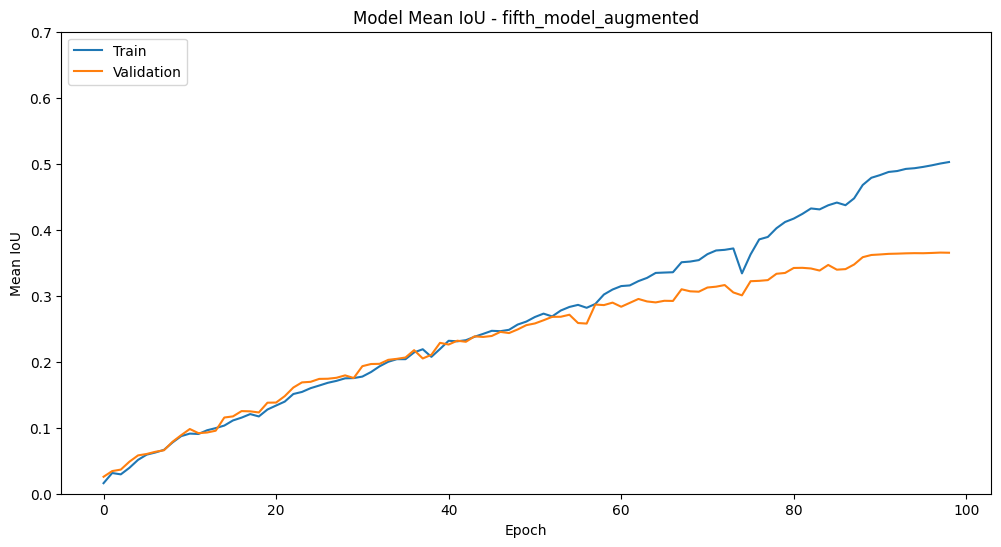

In [ ]:
log_path = os.path.join(models_path, model_name, f'{model_name}_log.csv')
plot_training_results(log_path, model_name)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})
plot_predictions(model, val_gen)

In [ ]:
model_path = os.path.join(models_path, model_name, f'{model_name}.keras')
model = load_model(model_path, custom_objects={'CustomMeanIoU': CustomMeanIoU(num_classes=len(CAMVID_CLASSES))})

# Ottieni il numero totale di parametri
total_params = model.count_params()

# Ottieni il numero di parametri trainabili e non trainabili
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])

print("Model Name: ", model_name)
print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

Model Name:  fifth_model_augmented
Total params: 138331552
Trainable params: 138331552
Non-trainable params: 0.0
